# Dataset Processing

1. Split `successful` and `unsuccessful` paths
2. For each human path, find the corresponding `shortest path length` from the `source` article to the `target` article. We make the assumption that `Wikispeedia` games with the same `shortest path length` have the same `difficulty` 
3. Next, take the human navigation paths with the same `difficulty` and further fix the `human path length`
4. Generate a matched dataset where the `successful` and `unsucessful` paths both have the same `shortest path length` **and** `human path length`

Use this matched dataset to answer the following question:

***When given X number of choices in the same difficulty game, how did successful and unsuccessful players differ in their clicking behaviour?***

In [1]:
import pandas as pd
import os

data_path = ".data/"
parent_folder_path = data_path + 'wikispeedia_paths-and-graph/'

paths_finished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                               sep='\t', skiprows=15, header=None)
                   .rename(columns={0:"ip",
                                    1:"timestamp",
                                    2:"duration",
                                    3:"path",
                                    4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))

## Split `successful` and `unsuccessful` paths. For each path, find the shortest length path from the `source` to the `target`

In [2]:
# first read the shortest path matrix
shortest_path_matrix = []

with open(data_path + 'wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)
        
# the matrix now stores all shortest paths from all source articles
len(shortest_path_matrix)

4604

In [9]:
articles

0       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1                             %C3%85land
2                     %C3%89douard_Manet
3                              %C3%89ire
4             %C3%93engus_I_of_the_Picts
                      ...               
4599                             Zionism
4600                           Zirconium
4601                           Zoroaster
4602                        Zuid-Gelders
4603                                Zulu
Name: 0, Length: 4604, dtype: object

In [21]:
# next, we need a list of all the article names. The order of the articles 
# is the same as the shortest_path_matrix as per the file descriptions

import urllib.parse
def str_url_format(word):
    """
    Article name preprocessing.
    
    Apply this function any time a new dataframe is loaded.
    """
    return (urllib.parse.unquote(word)
            .replace("_", " ")
            .strip()
            .lower())

article_names_cleaned = (pd.read_csv(data_path + 'wikispeedia_paths-and-graph/articles.tsv', 
                                     sep='\t', 
                                     skiprows=11,
                                     header=None)[0]
                         .apply(str_url_format)
                         .values
                         .tolist()
                        )

article_names_cleaned[:3]

['áedán mac gabráin', 'åland', 'édouard manet']

In [29]:
# for each human path, perform the following steps:
#      1. extract the source and target article
#      2. find the *index* in the article names list that corresponds to the source and target article
#      3. the corresponding *index* row in the shortest path matrix corresponds to the source article. 
#         from this list of numbers, use the target article *index* to find the *shortest path length*

def augment_with_shortest_path(df: pd.DataFrame, successful: bool) -> pd.DataFrame:
    """
    this function takes a Series and returns a DataFrame with the following columns:
       1. path
       2. source article
       3. target article
       4. shortest path length
       
    input:
       df: the Pandas DataFrame containing all the human navigation paths
       successful: a boolean indicating whether the paths were successful or not
    """
    # remove all paths with back-tracks
    df = df[~df['path'].str.contains('<')]        
    paths, human_path_lengths, source_articles, target_articles, shortest_paths = [], [], [], [], []
    
    # all information required for successful paths is in the path itself
    if successful:
        for human_path in df['path']:

            split_path = str_url_format(human_path).split(";")
            
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            target = split_path[-1]
            source_articles.append(source)
            target_articles.append(target)
    
    # unsuccessful paths require extraction of the target article from a separate column
    else:
        for human_path, target in zip(df['path'], df['target']):
            
            split_path = str_url_format(human_path).split(";")
            
            paths.append(";".join(split_path))
            # subtract 1 because we do not count the source article
            human_path_lengths.append(len(split_path)-1)

            source = split_path[0]
            source_articles.append(source)
            target_articles.append(target)
        
    for source, target in zip(source_articles, target_articles):
        source_index = article_names_cleaned.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = article_names_cleaned.index(target)
        except Exception:
            shortest_paths.append("N/A")
            continue
            
        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("Impossible")
        else:
            shortest_paths.append(int(shortest))
        
        
    # create the augmented DataFrame
    out = pd.DataFrame({
                      'path': paths,
                      'source_article': source_articles,
                      'target_article': target_articles,
                      'human_path_length': human_path_lengths,
                      'shortest_path_length': shortest_paths
                      })
    
    return out

In [30]:
successful_df = augment_with_shortest_path(df=paths_finished_df, successful=True)
# to investigate human behaviour, we remove all "Impossible paths" and also shortest_path_length = 0
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x != 'Impossible' and x != 0))]
# next, we will keep only shortest_path_lengths >= 3
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x >= 3))]

successful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
0,14th century;15th century;16th century;pacific...,14th century,african slave trade,8,3
1,14th century;europe;africa;atlantic slave trad...,14th century,african slave trade,4,3
2,14th century;niger;nigeria;british empire;slav...,14th century,african slave trade,7,3


In [31]:
unsuccessful_df = augment_with_shortest_path(df=paths_unfinished_df, successful=False)

# some target articles for unsuccessful paths were not provided in the plain_text folder, denoted in
# the DataFrame as "N/A". Remove these
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x != 'N/A' and x != 'Impossible'))]
# some unsuccesful paths only contain 1 article because the user didn't click anything
# these are less meaningful paths to analyze as we are interested in users who tried but failed
# we will keep paths where the human clicked at least 3 articles
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x >= 3))]
unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: x >= 3))]
unsuccessful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
1197,ozone;gas;plasma (physics);phase (matter);ther...,ozone,2-8-0,5,4
10039,jake gyllenhaal;mozambique;1st century;4th cen...,jake gyllenhaal,4-2-0,3,5
15522,rutherford b. hayes;american civil war;mississ...,rutherford b. hayes,2-6-0,5,5


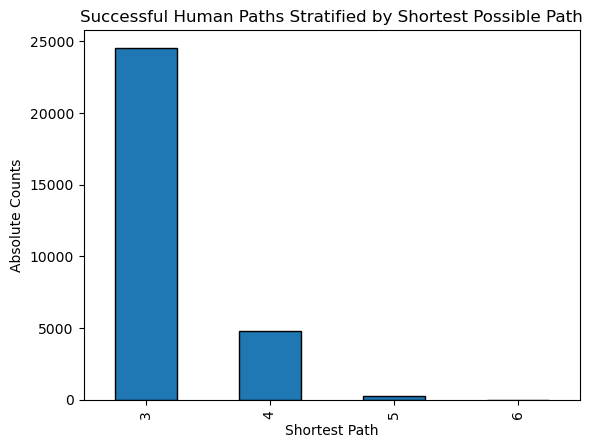

In [7]:
# take a look at the shortest_path distributions
import matplotlib.pyplot as plt

successful_counts = successful_df['shortest_path_length'].value_counts()
successful_counts.plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Shortest Path');
plt.title("Successful Human Paths Stratified by Shortest Possible Path");

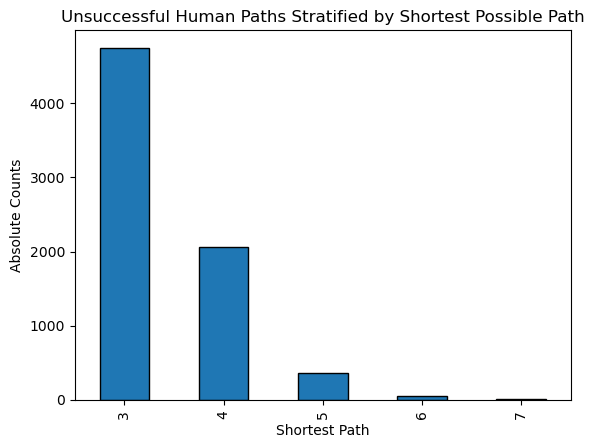

In [8]:
unsuccessful_counts = unsuccessful_df['shortest_path_length'].value_counts()
unsuccessful_counts.plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Shortest Path');
plt.title("Unsuccessful Human Paths Stratified by Shortest Possible Path");

The majority of `shortest path lengths` is 3 for both successful and unsuccessful paths. For this specific length, let's visualize the distribution of the actual human paths.

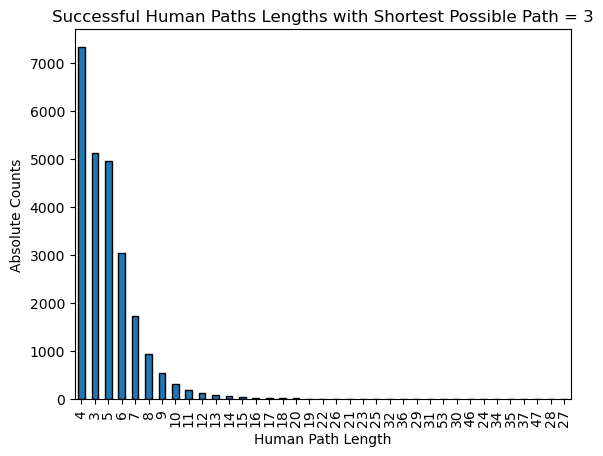

In [9]:
successful_human_path_lengths_3 = successful_df[successful_df['shortest_path_length'] == 3]
successful_human_path_lengths_3['human_path_length'].value_counts().plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Human Path Length');
plt.title("Successful Human Paths Lengths with Shortest Possible Path = 3");

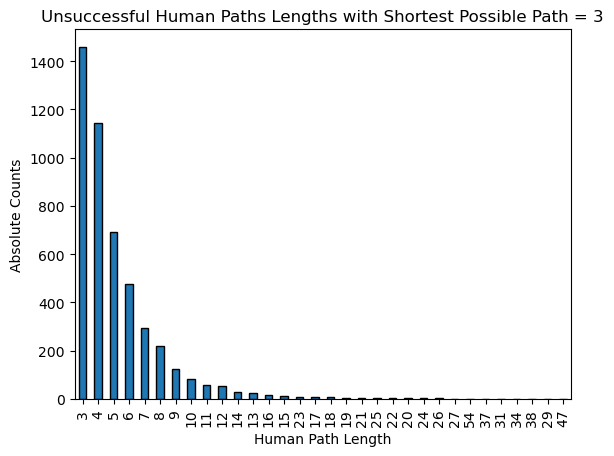

In [10]:
unsuccessful_human_path_lengths_3 = unsuccessful_df[unsuccessful_df['shortest_path_length'] == 3]
unsuccessful_human_path_lengths_3['human_path_length'].value_counts().plot(kind='bar', edgecolor='k')
plt.ylabel('Absolute Counts'); plt.xlabel('Human Path Length');
plt.title("Unsuccessful Human Paths Lengths with Shortest Possible Path = 3");

Given a `shortest path length` of 3, the majority of `human path lengths` are 3, 4, 5 for both successful and unsuccessful paths. Let's filter the corresponding DataFrames to only keep these path lengths. The matched analysis will be done with these lengths.

In [11]:
successful_df = successful_df[(successful_df['shortest_path_length'].apply(lambda x: x == 3))]
successful_df = successful_df[(successful_df['human_path_length'].apply(lambda x: 3 <= x <= 5))]
successful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
1,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3
5,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,5,3
6,14th_century;China;Gunpowder;Fire,14th_century,Fire,3,3


In [13]:
unsuccessful_df = unsuccessful_df[(unsuccessful_df['shortest_path_length'].apply(lambda x: x == 3))]
unsuccessful_df = unsuccessful_df[(unsuccessful_df['human_path_length'].apply(lambda x: 3 <= x <= 5))]
unsuccessful_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length
5,Agriculture;History_of_the_world;China;Yangtze...,Agriculture,Grand_Canal_of_China,3,3
13,Ape;Asia;Computer;Automobile,Ape,Tin,3,3
14,Symmetry;Science;Age_of_Enlightenment;Dark_Age...,Symmetry,Scottish_Episcopal_Church,5,3


At this point, we have filtered the successful and unsuccessful DataFrames by the following conditions:

1. Shortest path length = 3 --> we hypothesize that all paths have the same "difficulty" by enforcing this 
2. The actual human path lengths are 3,4,5 --> the majority of human paths are within these lengths

The next step is to perform matching of datasets. To make this process possible, we first augment both successful and unsuccessful DataFrames with `is_successful` Boolean condition.

In [17]:
successful_df['is_successful'] = 1
unsuccessful_df['is_successful'] = 0

# merge the successful and unsuccessful DataFrames
final_df = pd.concat([successful_df, unsuccessful_df])
final_df.reset_index(drop=True, inplace=True)

final_df.head(3)

# save the DataFrame
final_df.to_csv('final_df.csv')

# next, we will calculate "treatments" involving semantic distance metrics for the DataFrame

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful
0,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3,1
1,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,5,3,1
2,14th_century;China;Gunpowder;Fire,14th_century,Fire,3,3,1


## 2 . Document Similarity

### Similarity Between Wikipedia Articles: 'Bag-of-Words' Cosine Similarity Based on Word Frequencies

We are interested in measuring ***similarity*** between `Wikipedia` articles to investigate players' strategies in `Wikispeedia`. The proposed similarity is `Cosine Similarity` measured on word frequencies given a pair of articles. **Therefore, the assumption we make is that articles with similar occurrences of words are similar.** 

In order to mitigate similarity due to common English words such as "the", we apply a filter as follows:

1. Remove all `Stop` words as defined in `Scikit-learn`
* https://scikit-learn.org/stable/modules/feature_extraction.html#nqy18

2. Remove all white spaces and `\n` characters


3. Apply a scaled version of word frequency count as implemented in `TfidfTransformer` in `Scikit-learn`: 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

The cell blocks below show our data processing pipeline.

In [18]:
import os

base_path = data_path + 'plaintext_articles'
articles = os.listdir(base_path)
# sort the article names in alphabetical order. This is not strictly required
articles = sorted(articles)

def remove_duplicates_and_fix_names(articles: list):
    """this function parses all the articles provided in the plaintext folder and stores the
       names of all the articles after "cleaning" them (some articles containing accents have encoded names).
       The raw text from the files are also stored in a list after removing white spaces and empty lines."""
    
    def parse_text(article: str) -> str:
        """this helper function reads a raw text file and removes white spaces and empty lines."""
        with open(os.path.join(base_path, article)) as f:
            # remove white spaces
            raw_text = [line.rstrip() for line in f.readlines()]
            # remove empty lines
            raw_text = [line.strip() for line in raw_text if line != '']

            return str(raw_text)
    
    # some article names have errors - fix these
    article_names_cleaned, texts = [], []
    
    for article in articles:
        # the "%" character indicates an encoded name
        if "%" not in article:
            # store the article name
            article_names_cleaned.append(article)
            # store the raw text from the article
            texts.append(parse_text(article))
            
        else:
            with open(os.path.join(base_path, article), 'r') as f:
                # extract the correct name. It is always on the 3rd line of the article
                correct_name = f.readlines()[2].replace('\n', '')
                # store the article name
                article_names_cleaned.append(correct_name)
                # store the raw text from the article
                texts.append(parse_text(article))
                    
    
    # remove ".txt" from the article names
    article_names_cleaned = [article.replace('.txt', '') for article in article_names_cleaned]
    # remove list bracket from string casting of raw text
    texts = [text.replace('[', '') for text in texts]
    
    return article_names_cleaned, texts

article_names_cleaned, texts = remove_duplicates_and_fix_names(articles)

In [19]:
# count word frequency using sklearn out-of-the-box functions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

# remove common stop words
tfid_vectorizer = TfidfVectorizer(stop_words='english')
# apply CountVectorizer and TfidfTransform sequentially
matrix = tfid_vectorizer.fit_transform(texts)
matrix = matrix.todense()

# by default, "TfidfVectorizer" uses l2 norm and thus, to obtain the Cosine Similarity,
# we simply perform a dot product of the matrix
cosine_sim = pd.DataFrame(np.dot(np.array(matrix), np.array(matrix).T), columns=article_names_cleaned)
# assign the index names also as the article names. This is used for easy querying pairs of articles
cosine_sim.index = article_names_cleaned        
cosine_sim

,Áedán mac Gabráin,Åland,Édouard Manet,Éire,Óengus I of the Picts,€2 commemorative coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán mac Gabráin,1.000000,0.003680,0.006182,0.047190,0.183846,0.004210,0.008076,0.012168,0.013427,0.011928,...,0.004239,0.006244,0.001843,0.002172,0.003523,0.006111,0.001494,0.008908,0.001593,0.012721
Åland,0.003680,1.000000,0.008423,0.017851,0.004137,0.043866,0.007999,0.004936,0.004993,0.013233,...,0.004768,0.023149,0.002752,0.002160,0.007089,0.016041,0.003315,0.005287,0.008188,0.012883
Édouard Manet,0.006182,0.008423,1.000000,0.009609,0.006520,0.014643,0.011617,0.008879,0.011491,0.011438,...,0.010377,0.011835,0.004556,0.002780,0.011044,0.014414,0.004934,0.009887,0.005441,0.012838
Éire,0.047190,0.017851,0.009609,1.000000,0.049035,0.033312,0.012264,0.008489,0.033374,0.015251,...,0.009314,0.038388,0.006863,0.005671,0.005486,0.031955,0.005751,0.012004,0.004430,0.019581
Óengus I of the Picts,0.183846,0.004137,0.006520,0.049035,1.000000,0.006741,0.012741,0.013508,0.020239,0.012106,...,0.004763,0.008280,0.002700,0.002718,0.005656,0.008067,0.001780,0.009081,0.001923,0.015018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zionism,0.006111,0.016041,0.014414,0.031955,0.008067,0.017812,0.019210,0.021355,0.024060,0.023037,...,0.012631,0.038386,0.007253,0.003734,0.028964,1.000000,0.006372,0.016985,0.004575,0.026654
Zirconium,0.001494,0.003315,0.004934,0.005751,0.001780,0.006597,0.007255,0.005258,0.004183,0.005319,...,0.003589,0.010286,0.065117,0.038394,0.005937,0.006372,1.000000,0.005025,0.003256,0.004729
Zoroaster,0.008908,0.005287,0.009887,0.012004,0.009081,0.010104,0.021481,0.019697,0.017953,0.024732,...,0.008748,0.014037,0.005008,0.003395,0.009401,0.016985,0.005025,1.000000,0.003077,0.011154
Zuid-Gelders,0.001593,0.008188,0.005441,0.004430,0.001923,0.005124,0.004908,0.004378,0.002217,0.004719,...,0.003414,0.008758,0.002613,0.002273,0.004882,0.004575,0.003256,0.003077,1.000000,0.008353


In [20]:
# save the Cosine Similarity matrix so we do not have to re-compute it every time
np.save('cosine_similarity.npz', np.array(cosine_sim))

Text(0, 0.5, 'Absolute Counts')

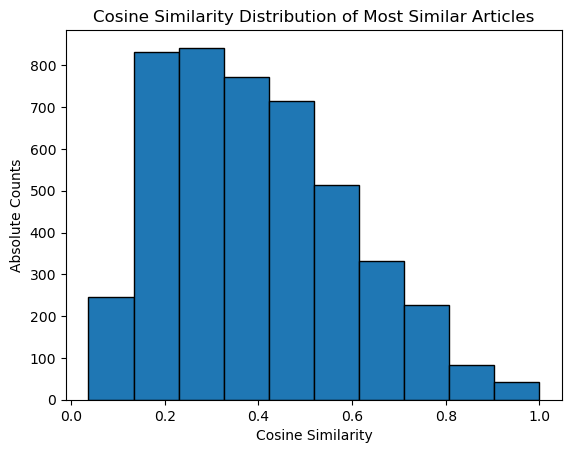

In [21]:
import matplotlib.pyplot as plt

# let's take a look at the Cosine Similarity distribution of the most similar article to a given article
most_similar = []
for idx in range(len(cosine_sim)):
    # index [-2] because index [-1] is always = 1 since it is a self similarity
    most_similar.append(sorted(cosine_sim.iloc[idx])[-2])
    
# plot the similarities
pd.Series(most_similar).plot(kind='hist', edgecolor='k')
plt.title("Cosine Similarity Distribution of Most Similar Articles")
plt.xlabel("Cosine Similarity"); plt.ylabel("Absolute Counts")

# there are no glaring red flags, e.g., most Cosine Similarities close to 0 or 1

In [22]:
# show a few concrete examples and see if our metric makes empirical sense
cosine_sim['Ukraine'].sort_values()

# results look reasonable

Primula              0.000621
Wren                 0.001130
Saxicola             0.001339
Angelica             0.001394
Nuthatch             0.001473
                       ...   
Kiev                 0.340883
History_of_Russia    0.356504
Polish-Soviet_War    0.382866
Hero_of_Ukraine      0.403438
Ukraine              1.000000
Name: Ukraine, Length: 4604, dtype: float64

In [23]:
cosine_sim['Zinc'].sort_values()
# results also look reasonable

Primula          0.000303
List_of_lakes    0.000396
Nuthatch         0.000659
Wren             0.000738
Woodpecker       0.000761
                   ...   
Metal            0.158449
Common_cold      0.222766
Cadmium          0.247857
Zinc_chloride    0.511672
Zinc             1.000000
Name: Zinc, Length: 4604, dtype: float64

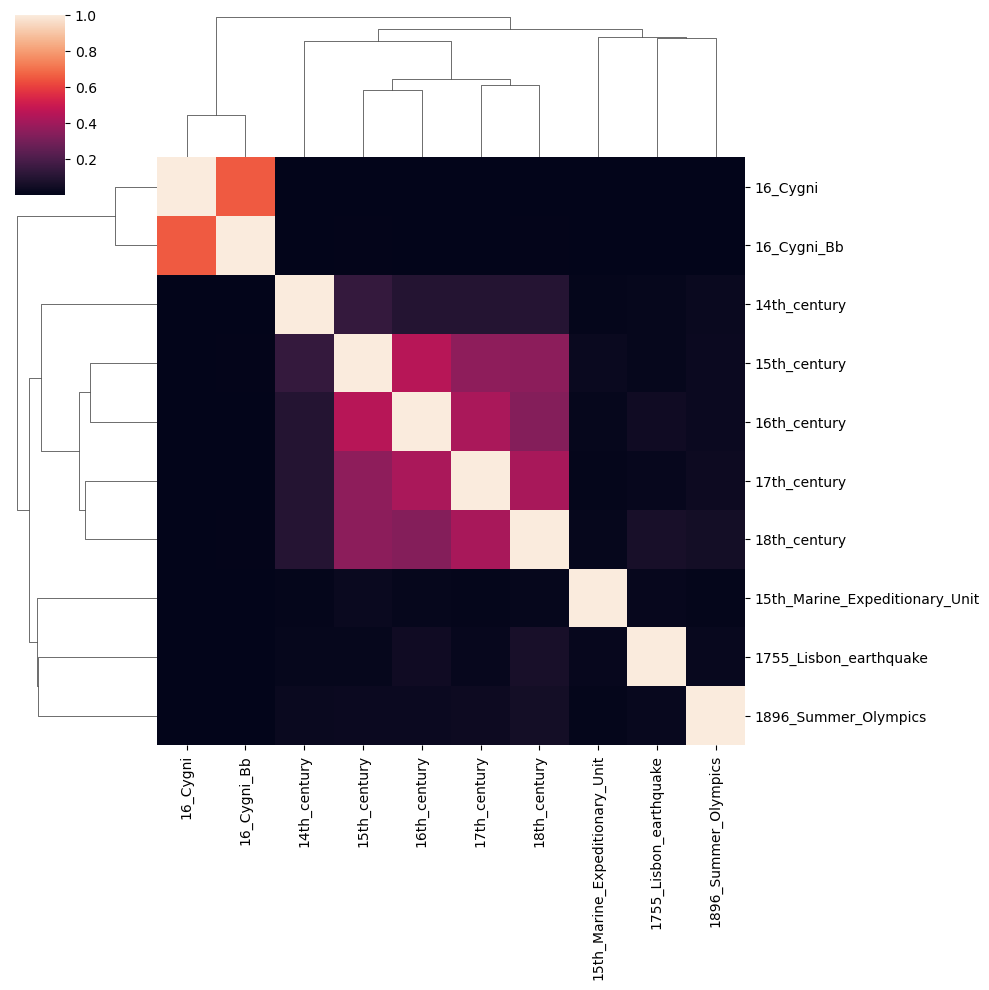

In [24]:
import seaborn as sns

# "Cygni" are star systems/extrasolar planets and thus are expected to be similar
# the time periods have some similarity
sns.clustermap(cosine_sim.iloc[10:20, 10:20])

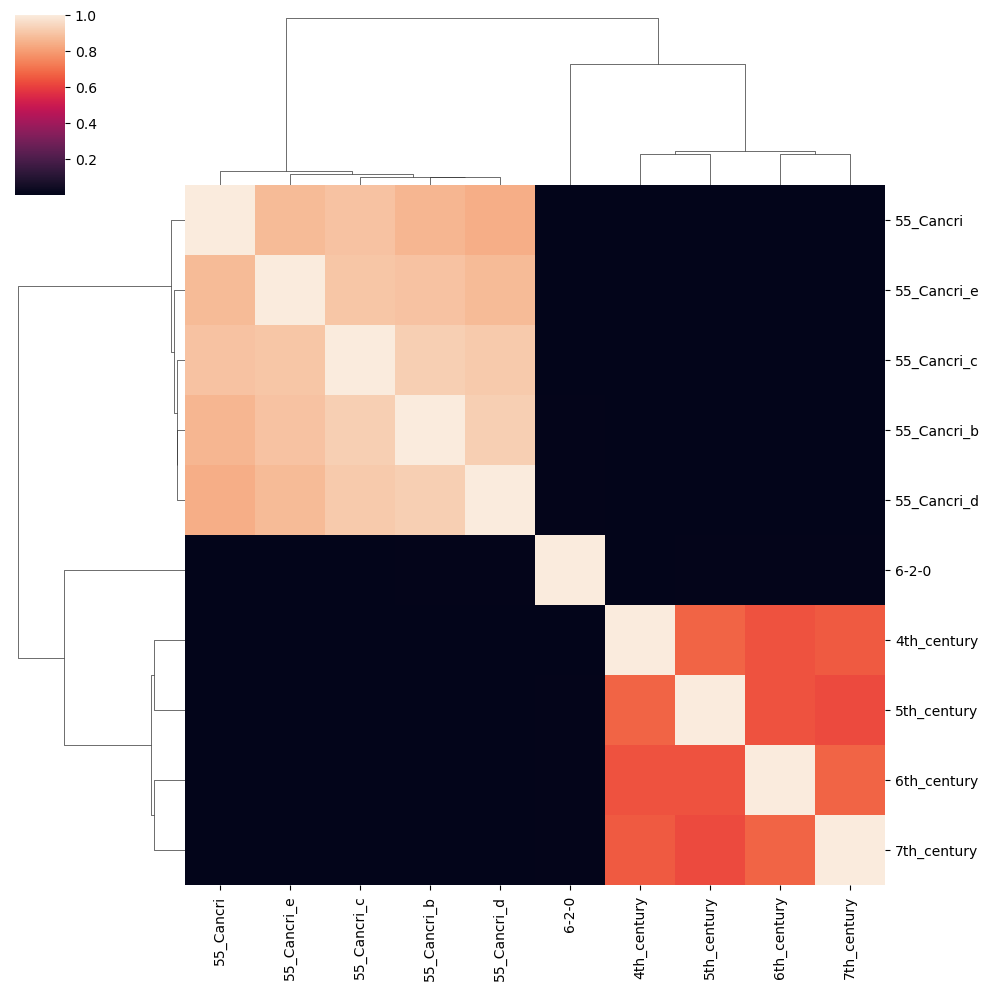

In [25]:
# "Cancri" are exoplanets and thus are expected to be similar
# we again see similarity between time periods
sns.clustermap(cosine_sim.iloc[50:60, 50:60])

In [26]:
# after confirming that the Cosine Similarity method is informative, we next show the function
# we will use to extract similarity of articles in a navigation path

# first show a hard-coded navigation path for illustration
navigation_path = '14th_century;Time;Light;Rainbow'

In [27]:
def get_path_cosine_similarity(path: str, matrix: pd.DataFrame, method: str='sequential') -> list:
    """this function takes a navigation path string and returns an array of the Cosine Similarity.
       Two methods are supported: 'sequential' (default) which measures the sequential similarity and 
       'target' which measures the similarity between the current article at the target article.
       
       Input:
       path: navigation path string
       matrix: pre-computed Cosine Similarity matrix
       method: measurement method (defaults to 'sequential')
       
       Return:
       list: list of similarity measures
    """
    
    # there is 1 article that is duplicated in the plaintext folder. Problematically, the duplicated
    # article has different names and navigation paths can point to these different names, yet the 
    # article is the same. This one exception is handled here. In the implementation, we do not have to 
    # worry about this particular article pointing back to itself as it is not possible
    
    # navigation paths are separated by ";"
    path = path.split(';')
    
    # if the path only contains the starting article, return None
    if len(path) == 1:
        return None
    
    path_sims = []
    
    def get_correct_name(query: str, base_path: str='../wikispeedia/plaintext_articles') -> str:
        """this nested function is called in case a path contains error characters.
           Returns the fixed path so it can be used to query the Cosine Similarity matrix."""
        if '_' in query and '%' not in query:
            return query
        elif query in ['Podcasting', 'Color', 'Fencing', 'Anemia', 'Quito']:
            return query
        else:
            with open(os.path.join(base_path, f'{query}.txt'), 'r') as f:
                out = f.readlines()[2].replace('\n', '')
                return out
    
    # compute the similarity between sequential nodes
    # output list length is N-1
    if method == 'sequential':
        for idx in range(0, len(path)-1, 1):
            try:
                path_sims.append(matrix.loc[path[idx]].loc[path[idx+1]])
            except Exception:
                # either path or both paths could be wrong - just "fix" both
                # treat the 1 exception due to duplicated file
                if get_correct_name(path[idx]) == 'Polish–Muscovite War (1605–1618)':
                    sim = float(cosine_sim.loc['Polish–Muscovite War (1605–1618)'].drop_duplicates()[get_correct_name(path[idx+1])])
                    path_sims.append(sim)
                    
                elif get_correct_name(path[idx+1]) == 'Polish–Muscovite War (1605–1618)':
                    sim = cosine_sim.loc[get_correct_name(path[idx])].drop_duplicates()['Polish–Muscovite War (1605–1618)']
                    path_sims.append(sim)
                    
                else:
                    path_sims.append(matrix.loc[get_correct_name(path[idx])].loc[get_correct_name(path[idx+1])])

                    
    # compute the similarity between the current node and the target node
    # output list length is N
    elif method == 'target':
        for idx in range(0, len(path), 1):
            try:
                path_sims.append(matrix.loc[path[idx]].loc[path[-1]])
            except Exception:
                # either path or both paths could be wrong - just "fix" both
                # treat the 1 exception due to duplicated file
                if get_correct_name(path[idx]) == 'Polish–Muscovite War (1605–1618)':
                    sim = cosine_sim.loc['Polish–Muscovite War (1605–1618)'].drop_duplicates()[get_correct_name(path[-1])]
                    path_sims.append(sim)
                    
                elif get_correct_name(path[-1]) == 'Polish–Muscovite War (1605–1618)':
                    sim = float(cosine_sim.loc[get_correct_name(path[idx])].drop_duplicates()['Polish–Muscovite War (1605–1618)'])
                    path_sims.append(sim)
                    
                else:
                    path_sims.append(matrix.loc[get_correct_name(path[idx])].loc[get_correct_name(path[-1])])
    
    else:
        raise ValueError('Unsupported similarity method: choose from "sequential" or "target".')
        
    return path_sims

In [28]:
# print the navigation path for reference
print(navigation_path.split(';'))

# show the "sequential" method
sequential_sims = get_path_cosine_similarity(path=navigation_path,
                                             matrix=cosine_sim,
                                             method='sequential')
# intepreted as:
# sim(14th_century, Time) = 0.031
# sim(Time, Light) = 0.147
# sim(Light, Rainbow) = 0.158
# the similarity list is always N-1 in length, N = # nodes
sequential_sims

['14th_century', 'Time', 'Light', 'Rainbow']


[0.03148221080256591, 0.14746128033868, 0.15783064270493327]

In [29]:
# show the "target" method
target_sims = get_path_cosine_similarity(path=navigation_path,
                                         matrix=cosine_sim,
                                         method='target')
# intepreted as:
# sim(14th_century, Rainbow) = 0.008
# sim(Time, Rainbow) = 0.035
# sim(Light, Rainbow) = 0.158
# sim(Rainbow, Rainbow) = 1 (the path was successful so similarity is 1)
# the similarity list is now N in length, N = # nodes

# note: paths where the last index != 1 means the path was unsuccessful
target_sims

[0.00764736982703648,
 0.03486926301697003,
 0.15783064270493327,
 1.0000000000000004]

In [35]:
# calculate the "sequential" and "target" cosine similarities and augment the DataFrame with these metrics
final_df['path_seq_cosine_sim'] = final_df['path'].apply(lambda x: get_path_cosine_similarity(x, matrix=cosine_sim))
final_df['path_target_cosine_sim'] = final_df['path'].apply(lambda x: get_path_cosine_similarity(x, matrix=cosine_sim, method='target'))

final_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,path_seq_cosine_sim,path_target_cosine_sim
0,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3,1,"[0.06712629693232745, 0.20733258691597292, 0.3...","[0.030770302481984573, 0.1043890593428143, 0.3..."
1,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,5,3,1,"[0.06712629693232745, 0.17836530050620195, 0.3...","[0.012741833088878754, 0.02487036054931131, 0...."
2,14th_century;China;Gunpowder;Fire,14th_century,Fire,3,3,1,"[0.06407585068130972, 0.0719709239718701, 0.07...","[0.016703039404061093, 0.03765346608762515, 0...."


In [36]:
# next, write a function that returns whether the Cosine similarities in a navigation path are increasing/decreasing
def sims_to_bool_path(path: str):
    """this function takes a navgiation path as input and returns the path with same dimensions
       containing Booleans denoting whether the Cosine similarity is increasing"""
    bool_path = []
    for idx in range(len(path)-1):
        if path[idx+1] > path[idx]:
            bool_path.append(True)
        else:
            bool_path.append(False)
    
    return bool_path
        

Augment the DataFrame with the Cosine similarity Boolean metric.

In [37]:
final_df['path_seq_boolean'] = final_df['path_seq_cosine_sim'].apply(sims_to_bool_path)
final_df['path_target_boolean'] = final_df['path_target_cosine_sim'].apply(sims_to_bool_path)

final_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,path_seq_cosine_sim,path_target_cosine_sim,path_seq_boolean,path_target_boolean
0,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3,1,"[0.06712629693232745, 0.20733258691597292, 0.3...","[0.030770302481984573, 0.1043890593428143, 0.3...","[True, True, True]","[True, True, True, True]"
1,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,5,3,1,"[0.06712629693232745, 0.17836530050620195, 0.3...","[0.012741833088878754, 0.02487036054931131, 0....","[True, True, False, False]","[True, True, True, True, True]"
2,14th_century;China;Gunpowder;Fire,14th_century,Fire,3,3,1,"[0.06407585068130972, 0.0719709239718701, 0.07...","[0.016703039404061093, 0.03765346608762515, 0....","[True, False]","[True, True, True]"


The `treatment` we want to investigate is `strictly increasing similarity`. 

In [41]:
# this function filters paths that only contain strictly increasing Cosine similarities
def filter_strictly_increasing_sims(path_list: list):
    return False if False in path_list else True

final_df['seq_strictly_increasing'] = final_df['path_seq_boolean'].apply(filter_strictly_increasing_sims)
final_df['target_strictly_increasing'] = final_df['path_target_boolean'].apply(filter_strictly_increasing_sims)

final_df.head(3)

,path,source_article,target_article,human_path_length,shortest_path_length,is_successful,path_seq_cosine_sim,path_target_cosine_sim,path_seq_boolean,path_target_boolean,seq_strictly_increasing,target_strictly_increasing
0,14th_century;Europe;Africa;Atlantic_slave_trad...,14th_century,African_slave_trade,4,3,1,"[0.06712629693232745, 0.20733258691597292, 0.3...","[0.030770302481984573, 0.1043890593428143, 0.3...","[True, True, True]","[True, True, True, True]",True,True
1,14th_century;Europe;North_America;United_State...,14th_century,John_F._Kennedy,5,3,1,"[0.06712629693232745, 0.17836530050620195, 0.3...","[0.012741833088878754, 0.02487036054931131, 0....","[True, True, False, False]","[True, True, True, True, True]",False,True
2,14th_century;China;Gunpowder;Fire,14th_century,Fire,3,3,1,"[0.06407585068130972, 0.0719709239718701, 0.07...","[0.016703039404061093, 0.03765346608762515, 0....","[True, False]","[True, True, True]",False,True


We are now ready to perform a matched study to investigate whether users who click links with increasing Cosine similarity, i.e., based on semantic meaning, are more successful.

We previously filtered the dataset to include only `shortest_path_length = 3` for both successful and unsuccessful paths to fix the `difficulty`. We next kept only `human_path_length = 3,4,5` as these were the majority lengths for both successful and unsuccessful. We did this as our research question is:

***When given X number of choices in the same difficulty game, how did successful and unsuccessful players differ in their clicking behaviour?*** 

where X is `human_path_length = 3,4,5`.


***Now, we will perform our analysis separately for each `human_path_length`.***

In [43]:
# the matching algorithm requires some computation time
# compute the matched DataFrames all at once and save them so they can be read into memory directly

# there are 2 treatments
#    1. strictly increasing *sequential* Cosine similarity
#    2. strictly increasing *target* Cosine similarity

# there are also 3 conditions we filter on
#    1. human_path_length = 3
#    2. human_path_length = 4
#    3. human_path_length = 5

import networkx as nx

for treatment in ['seq_strictly_increasing', 'target_strictly_increasing']:
    for length in [3,4,5]:
    
        treatment_df = final_df[final_df[treatment] == True]
        control_df = final_df[final_df[treatment] == False]

        G = nx.Graph()

        for control_id, control_row in control_df.iterrows():
            for treatment_id, treatment_row in treatment_df.iterrows():
                # Adds an edge only for the same human path length
                if (control_row['human_path_length'] == length and treatment_row['human_path_length'] == length):
                    G.add_edge(control_id, treatment_id)

        matching = nx.max_weight_matching(G)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df = final_df.iloc[matched]

        # save balanced_df
        balanced_df.to_csv(f'{treatment}_{length}.csv')

In [81]:
# next, perform logistic regression on each treatment with fixed human path length

# read all the matched DataFrames into memory
df_seq_3 = pd.read_csv('seq_strictly_increasing_3.csv')
df_seq_4 = pd.read_csv('seq_strictly_increasing_4.csv')
df_seq_5 = pd.read_csv('seq_strictly_increasing_5.csv')

df_target_3 = pd.read_csv('target_strictly_increasing_3.csv')
df_target_4 = pd.read_csv('target_strictly_increasing_4.csv')
df_target_5 = pd.read_csv('target_strictly_increasing_5.csv')

# store all results in a dictionary
results = {}

import statsmodels.formula.api as smf

for df, experiment_name in zip([df_seq_3, df_seq_4, df_seq_5, df_target_3, df_target_4, df_target_5],
                               ['Sequential 3', 'Sequential 4', 'Sequential 5', 'Target 3', 'Target 4', 'Target 5']):
    
    if 'Sequential' in experiment_name:
        mod = smf.logit(formula='is_successful ~  seq_strictly_increasing', data=df)
    else:
        mod = smf.logit(formula='is_successful ~  target_strictly_increasing', data=df)
        
    res = mod.fit()
    
    # dictionary to store the coefficients and p-values of the current experiment
    curr_analysis = {}
    # store the intercept
    curr_analysis['Intercept'] = res.params[0]
    # store the intercept p-value
    curr_analysis['Intercept p-value'] = res.pvalues[0]
    # store the coefficient for **strictly increasing Cosine similarity**
    curr_analysis['Coefficient'] = res.params[1]
    # store the coefficient p-value
    curr_analysis['Coefficient p-value'] = res.pvalues[1]
    
    results[experiment_name] = curr_analysis
    
results_df = pd.DataFrame(results)

Optimization terminated successfully.
         Current function value: 0.579321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400789
         Iterations 6
         Current function value: 0.117964
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.350626
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.253927
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.423189
         Iterations 7


/Users/jeguo/miniconda3/envs/cheminformatics/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
results_df

,Sequential 3,Sequential 4,Sequential 5,Target 3,Target 4,Target 5
Intercept,4.465737e-01,-1.343573e+00,-20.808148,4.021706e-02,1.365146e+00,9.001758e-01
Intercept p-value,1.147422e-27,9.580997e-86,0.992253,5.365566e-01,5.494593e-218,1.628451e-72
Coefficient,9.873246e-01,3.714911e+00,23.502776,6.809909e+00,6.732889e+00,1.737782e+00
Coefficient p-value,7.690060e-52,1.873209e-208,0.991250,1.106240e-11,1.749179e-11,4.183265e-63


The syntax in the above table is interpreted as :
* `Sequential` means the strictly increasing Cosine similarity was measured for sequential articles
* `Target` means the strictly increasing Cosine similarity was measured based on sequential article compared to the target article
* The number indicates the `human path length` fixed. Previously, we also fixed that the `shortest path length` is 3. 

Our research question is:

***When given X number of choices in the same difficulty game, how did successful and unsuccessful players differ in their clicking behaviour?*** 

Based on the above table, the `p-values` for both the `incercept` and `coefficient` for `logistic regression` are significant for all experiments except 1 (`Sequential 5`). The interpretation for all experiment findings are similar. Concretely, consider the experiment `Sequential 3`. The interpretation is:

* ***Given a `shortest path length` of 3 (fixed difficulty) and given a `human path length` of 3 (when the human makes 3 choices on article clicks), clicking articles with increasing Cosine similarity between sequential articles (as a proxy to measure semantic meaning), leads to more successful outcomes.***

For `Target` experiments have a similar interpretation. Concretely, consider the experiment `Target 5`:

* ***Given a `shortest path length` of 3 (fixed difficulty) and given a `human path length` of 5 (when the human makes 5 choices on article clicks), clicking articles with increasing Cosine similarity between the current article and the target article (as a proxy to measure semantic meaning), leads to more successful outcomes.***

**These findings are interesting and suggest that (potentially contrarily to common sense) clicking articles based on semantic meaning can lead to more successful outcomes in the `Wikispeedia` game (at least the current version we are investigating).**